In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from integrals import *
from scipy.optimize import fmin, minimize_scalar, minimize, root_scalar

In [9]:
def annealed_entropy(m,e,p):
    H = -(1+m)*np.log((1+m)/2)/2 - (1-m)*np.log((1-m)/2)/2
    return H - e**2*(1-m**p)**2

In [12]:
p=10
blend = 0.85
ms = np.linspace(0.0, 0.99, 1_000)
Teqs = np.array([0.64,0.65,0.66,0.67,0.68,0.69])

es = -1 / (2 * Teqs)

Temps = np.empty((len(es), len(ms)))
qs = np.empty((len(Temps), len(ms)))
hs = np.empty((len(Temps), len(ms)))
fs = np.empty((len(Temps), len(ms)))
deltafs = np.empty((len(Temps), len(ms)))
entropys = np.empty((len(Temps), len(ms)))
dAT_cond = np.empty((len(Temps), len(ms)))

for jdx, e in enumerate(tqdm(es)):
    for idx, m in enumerate(ms):
        err = 1
        q = m
        h = 0.1

        while err > 1e-9:
            h_new = root_scalar(
                lambda h: compute_m_FP(m, q, h, p, e) - m, bracket=[-20, 20], xtol=1e-12
            ).root
            q_new = compute_q_FP(m, q, h_new, p, e)

            err = max(abs(h_new - h), abs(q_new - q))
            h = blend * h + (1 - blend) * h_new
            q = blend * q + (1 - blend) * q_new

        qs[jdx, idx] = q
        hs[jdx, idx] = h
        Temps[jdx, idx] = 1 / beta_q_e(q, m, e,p)
        fs[jdx, idx] = f_FP(m, q, h, p, e)
        deltafs[jdx, idx] = deltaf_FP(m, q, h, p, e)
        entropys[jdx, idx] = s_FP(m, q, h, p, e)
        dAT_cond[jdx, idx] = dAT_condition(
            q, m, h, beta_q_e(q, m, e,p), beta_q_e(q, m, e,p) / 2, p
        )

  0%|          | 0/6 [00:00<?, ?it/s]

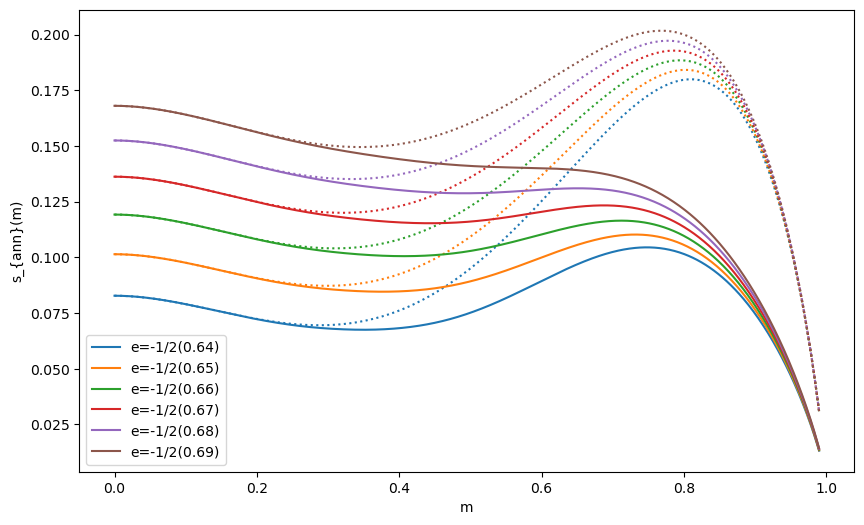

In [33]:
plt.figure(figsize=(10,6))
for i, e in enumerate(es):
    s = annealed_entropy(ms, e, p)
    plt.plot(ms, s, ':', color=f'C{i}')
    plt.plot(ms, entropys[i], label=f'e=-1/2({Teqs[i]:.2f})', color=f'C{i}')
plt.xlabel('m')
plt.ylabel(r's_{ann}(m)')
plt.legend()

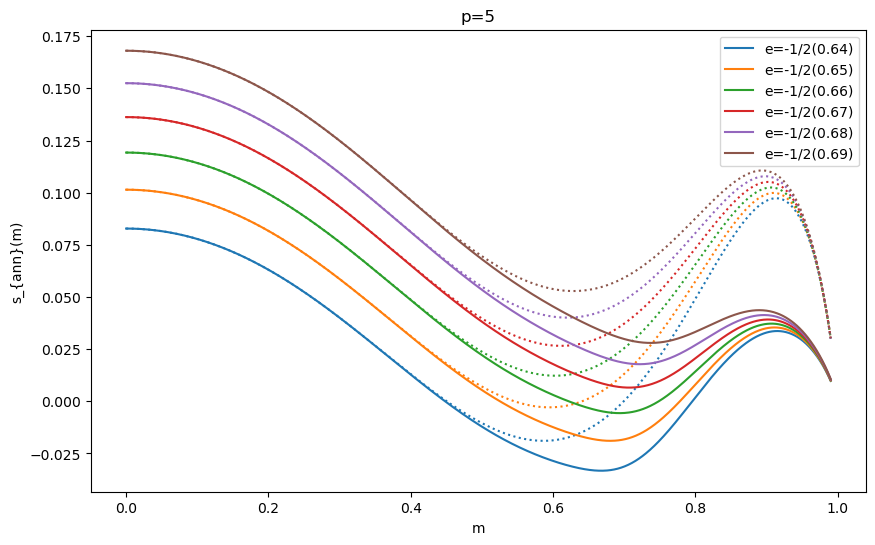

In [11]:
plt.figure(figsize=(10,6))
plt.title('p={}'.format(p))
for i, e in enumerate(es):
    s = annealed_entropy(ms, e, p)
    plt.plot(ms, s, ':', color=f'C{i}')
    plt.plot(ms, entropys[i], label=f'e=-1/2({Teqs[i]:.2f})', color=f'C{i}')
plt.xlabel('m')
plt.ylabel(r's_{ann}(m)')
plt.legend()

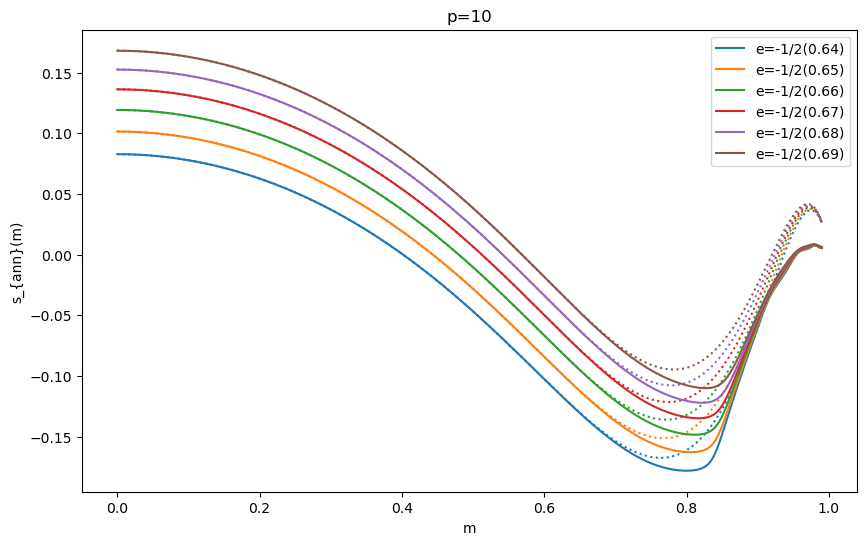

In [13]:
plt.figure(figsize=(10,6))
plt.title('p={}'.format(p))
for i, e in enumerate(es):
    s = annealed_entropy(ms, e, p)
    plt.plot(ms, s, ':', color=f'C{i}')
    plt.plot(ms, entropys[i], label=f'e=-1/2({Teqs[i]:.2f})', color=f'C{i}')
plt.xlabel('m')
plt.ylabel(r's_{ann}(m)')
plt.legend()

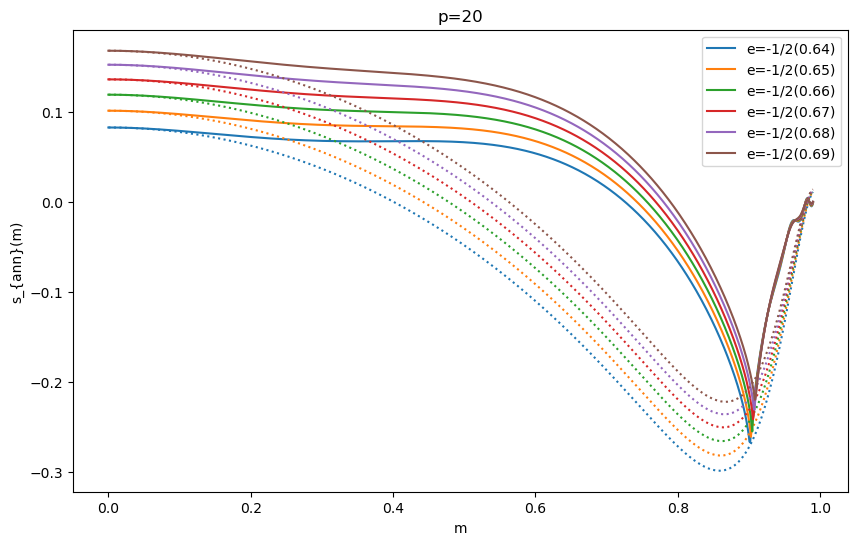

In [44]:
plt.figure(figsize=(10,6))
plt.title('p={}'.format(p))
for i, e in enumerate(es):
    s = annealed_entropy(ms, e, p)
    plt.plot(ms, s, ':', color=f'C{i}')
    plt.plot(ms, entropys[i], label=f'e=-1/2({Teqs[i]:.2f})', color=f'C{i}')
plt.xlabel('m')
plt.ylabel(r's_{ann}(m)')
plt.legend()

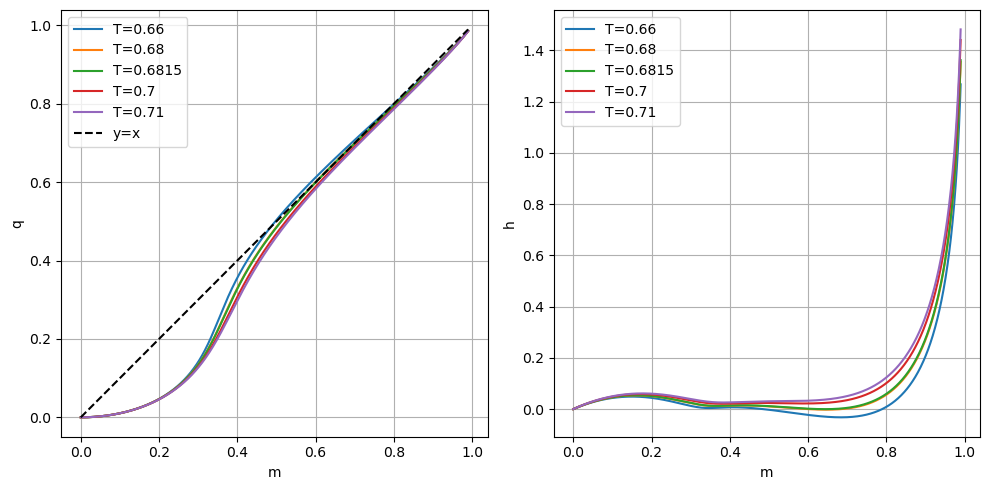

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for jdx, T in enumerate(Temps):
    ax[0].plot(ms, qs[jdx,:], '-', label=f'T={T}')
    ax[1].plot(ms, hs[jdx,:], '-', label=f'T={T}')
ax[0].plot(ms, ms, 'k--', label='y=x')
ax[0].set_xlabel('m')
ax[0].set_ylabel('q')
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel('m')
ax[1].set_ylabel('h')
ax[1].legend()
ax[1].grid()
fig.tight_layout()

  0%|          | 0/100 [00:00<?, ?it/s]

(35215,)
(100, 1000)


Text(0.5, 0.92, 'p = 3')

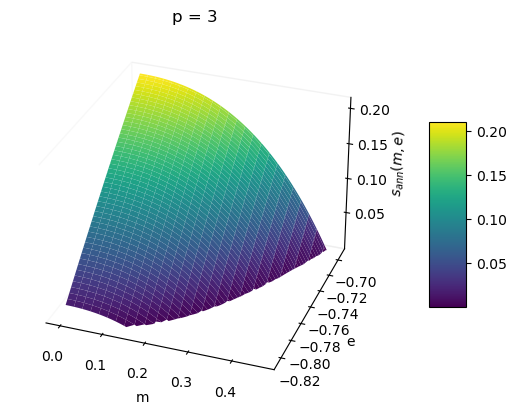

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.view_init(30, -70)

m_mesh, es_mesh = np.meshgrid(ms, es)
# z = np.zeros_like(m_mesh)

sAnns = np.empty((len(es), len(ms)))
for jdx, e in enumerate(tqdm(es)):
    for idx, m in enumerate(ms):
        sAnns[jdx, idx] = annealed_entropy(m, e, p)

positive_idx = sAnns > 0
print(sAnns[positive_idx].shape)
print(np.where(positive_idx, sAnns, np.nan).shape)

surf = ax.plot_surface(np.where(positive_idx, m_mesh, np.nan), np.where(positive_idx, es_mesh, np.nan), np.where(positive_idx, sAnns, np.nan), cmap="viridis", edgecolor="none")
# ax.plot_surface(m_mesh, es_mesh, z, color="black", alpha=0.5, edgecolor="none")

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)

ax.set_xlabel("m")
ax.set_ylabel("e")
ax.set_zlabel(r"$s_{ann}(m,e)$")
ax.set_title(f"p = {p:d}")

In [41]:
blend = 0.8
p_value = 3
ms = np.linspace(0.001, 0.999, 5_000)

#Ts = np.linspace(0.65138, 0.65139, 10)
Ts = np.linspace(0.63, 0.69, 10)
qs = np.empty((len(Ts), len(ms)))
hs = np.empty((len(Ts), len(ms)))
deltafs = np.empty((len(Ts), len(ms)))
fs = np.empty((len(Ts), len(ms)))

for jdx, T in enumerate(tqdm(Ts)):
    J0 = 1 / (2 * T)
    q_init = 0.8
    for idx, m in enumerate(ms):
        err = 1
        q = q_init
        while err > 1e-7:
            q_new = compute_q_standard(m, q, p_value, 1 / T, J0)

            err = abs(q_new - q)
            q = blend * q + (1 - blend) * q_new
            
        q_init = q

        qs[jdx, idx] = q
        fs[jdx, idx] = compute_free_energy_standard(m, q, p_value, 1 / T, J0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for idx, T in enumerate(Ts):
    plt.plot(ms, fs[idx, :] - fs[idx, 0], label=f"T={T:.5f}")
    peaks, _ = find_peaks(-(fs[idx, :] - fs[idx, 0]))
    plt.plot(
        ms[peaks],
        fs[idx, peaks] - fs[idx, 0],
        "o",
        color=plt.gca().lines[-1].get_color(),
    )

plt.title(f"p = {p_value:d}")
plt.xlabel("m")
plt.grid()
plt.ylabel("f(m)")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(-fs[:, -1])
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.xlim(0.78,0.85)
plt.ylim(-0.000005, 0.000005)

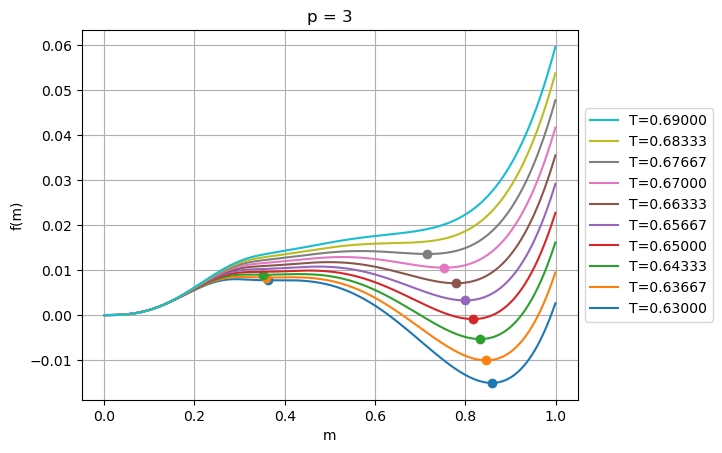

In [42]:
for idx, T in enumerate(Ts):
    plt.plot(ms, fs[idx, :] - fs[idx, 0], label=f"T={T:.5f}")
    peaks, _ = find_peaks(-(fs[idx, :] - fs[idx, 0]))
    plt.plot(
        ms[peaks],
        fs[idx, peaks] - fs[idx, 0],
        "o",
        color=plt.gca().lines[-1].get_color(),
    )

plt.title(f"p = {p_value:d}")
plt.xlabel("m")
plt.grid()
plt.ylabel("f(m)")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(-fs[:, -1])
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
#plt.xlim(0.78,0.85)
#plt.ylim(-0.000005, 0.000005)

In [12]:
Ts

array([0.65138   , 0.65138111, 0.65138222, 0.65138333, 0.65138444,
       0.65138556, 0.65138667, 0.65138778, 0.65138889, 0.65139   ])

$T_k = 0.651385$

## $p=4$

In [43]:
blend = 0.8
p_value = 4
ms = np.linspace(0.001, 0.999, 5_000)

#Ts = np.linspace(0.61685, 0.6169, 10)
Ts = np.linspace(0.6, 0.7, 10)
qs = np.empty((len(Ts), len(ms)))
hs = np.empty((len(Ts), len(ms)))
deltafs = np.empty((len(Ts), len(ms)))
fs = np.empty((len(Ts), len(ms)))

for jdx, T in enumerate(tqdm(Ts)):
    J0 = 1 / (2 * T)
    q_init = 0.8
    for idx, m in enumerate(ms):
        err = 1
        q = q_init
        while err > 1e-7:
            q_new = compute_q_standard(m, q, p_value, 1 / T, J0)

            err = abs(q_new - q)
            q = blend * q + (1 - blend) * q_new
            
        q_init = q

        qs[jdx, idx] = q
        fs[jdx, idx] = compute_free_energy_standard(m, q, p_value, 1 / T, J0)

  0%|          | 0/10 [00:00<?, ?it/s]

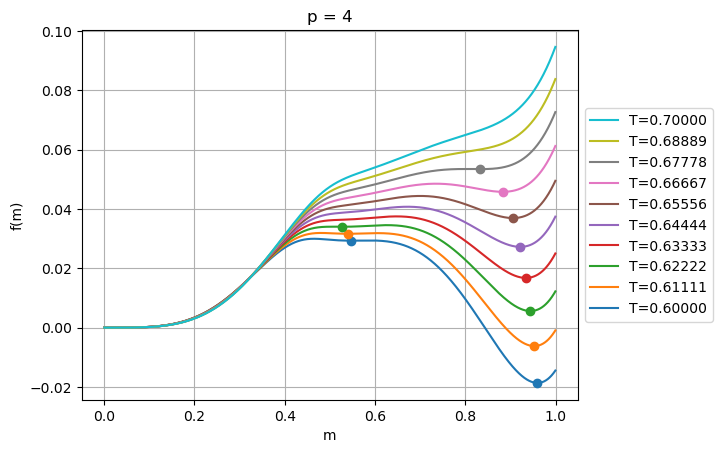

In [44]:
for idx, T in enumerate(Ts):
    plt.plot(ms, fs[idx, :] - fs[idx, 0], label=f"T={T:.5f}")
    peaks, _ = find_peaks(-(fs[idx, :] - fs[idx, 0]))
    plt.plot(
        ms[peaks],
        fs[idx, peaks] - fs[idx, 0],
        "o",
        color=plt.gca().lines[-1].get_color(),
    )

plt.title(f"p = {p_value:d}")
plt.xlabel("m")
plt.grid()
plt.ylabel("f(m)")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(-fs[:, -1])
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

#plt.xlim(0.9,1.)
#plt.ylim(-0.00001, 0.00001)

In [23]:
Ts

array([0.61685   , 0.61685556, 0.61686111, 0.61686667, 0.61687222,
       0.61687778, 0.61688333, 0.61688889, 0.61689444, 0.6169    ])

$T_k = 0.616883$

## $p=5$

In [45]:
blend = 0.8
p_value = 5
ms = np.linspace(0.001, 0.999, 5_000)

#Ts = np.linspace(0.60693, 0.60696, 10)
Ts = np.linspace(0.6, 0.72, 10)
qs = np.empty((len(Ts), len(ms)))
hs = np.empty((len(Ts), len(ms)))
deltafs = np.empty((len(Ts), len(ms)))
fs = np.empty((len(Ts), len(ms)))

for jdx, T in enumerate(tqdm(Ts)):
    J0 = 1 / (2 * T)
    q_init = 0.8
    for idx, m in enumerate(ms):
        err = 1
        q = q_init
        while err > 1e-7:
            q_new = compute_q_standard(m, q, p_value, 1 / T, J0)

            err = abs(q_new - q)
            q = blend * q + (1 - blend) * q_new
            
        q_init = q

        qs[jdx, idx] = q
        fs[jdx, idx] = compute_free_energy_standard(m, q, p_value, 1 / T, J0)

  0%|          | 0/10 [00:00<?, ?it/s]

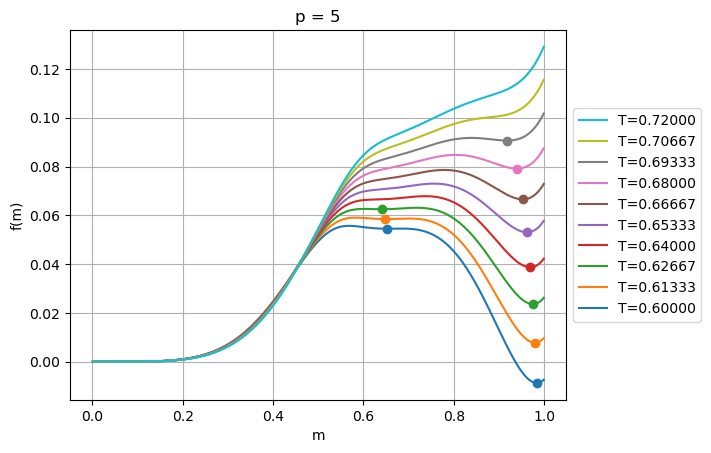

In [46]:
for idx, T in enumerate(Ts):
    plt.plot(ms, fs[idx, :] - fs[idx, 0], label=f"T={T:.5f}")
    peaks, _ = find_peaks(-(fs[idx, :] - fs[idx, 0]))
    plt.plot(
        ms[peaks],
        fs[idx, peaks] - fs[idx, 0],
        "o",
        color=plt.gca().lines[-1].get_color(),
    )

plt.title(f"p = {p_value:d}")
plt.xlabel("m")
plt.grid()
plt.ylabel("f(m)")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(-fs[:, -1])
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

#plt.xlim(0.97,0.99)
#plt.ylim(-0.00002, 0.00002)

In [31]:
Ts

array([0.60693   , 0.60693333, 0.60693667, 0.60694   , 0.60694333,
       0.60694667, 0.60695   , 0.60695333, 0.60695667, 0.60696   ])

$T_k = 0.60695$

### $T_d$

In [38]:
blend = 0.8
p_value = 5
ms = np.linspace(0.001, 0.999, 5_000)

Ts = np.linspace(0.6995, 0.7004, 10)
qs = np.empty((len(Ts), len(ms)))
hs = np.empty((len(Ts), len(ms)))
deltafs = np.empty((len(Ts), len(ms)))
fs = np.empty((len(Ts), len(ms)))

for jdx, T in enumerate(tqdm(Ts)):
    J0 = 1 / (2 * T)
    q_init = 0.8
    for idx, m in enumerate(ms):
        err = 1
        q = q_init
        while err > 1e-7:
            q_new = compute_q_standard(m, q, p_value, 1 / T, J0)

            err = abs(q_new - q)
            q = blend * q + (1 - blend) * q_new
            
        q_init = q

        qs[jdx, idx] = q
        fs[jdx, idx] = compute_free_energy_standard(m, q, p_value, 1 / T, J0)

  0%|          | 0/10 [00:00<?, ?it/s]

(0.095, 0.0962)

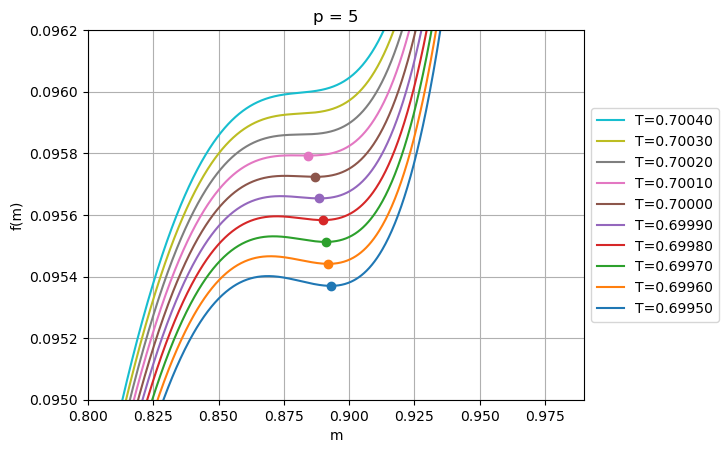

In [40]:
for idx, T in enumerate(Ts):
    plt.plot(ms, fs[idx, :] - fs[idx, 0], label=f"T={T:.5f}")
    peaks, _ = find_peaks(-(fs[idx, :] - fs[idx, 0]))
    plt.plot(
        ms[peaks],
        fs[idx, peaks] - fs[idx, 0],
        "o",
        color=plt.gca().lines[-1].get_color(),
    )

plt.title(f"p = {p_value:d}")
plt.xlabel("m")
plt.grid()
plt.ylabel("f(m)")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(-fs[:, -1])
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.xlim(0.8,0.99)
plt.ylim(0.095, 0.0962)

$T_d = 0.7001$